Starting Enhanced Activity Analysis...

Analyzing The Fellowship of the Ring...


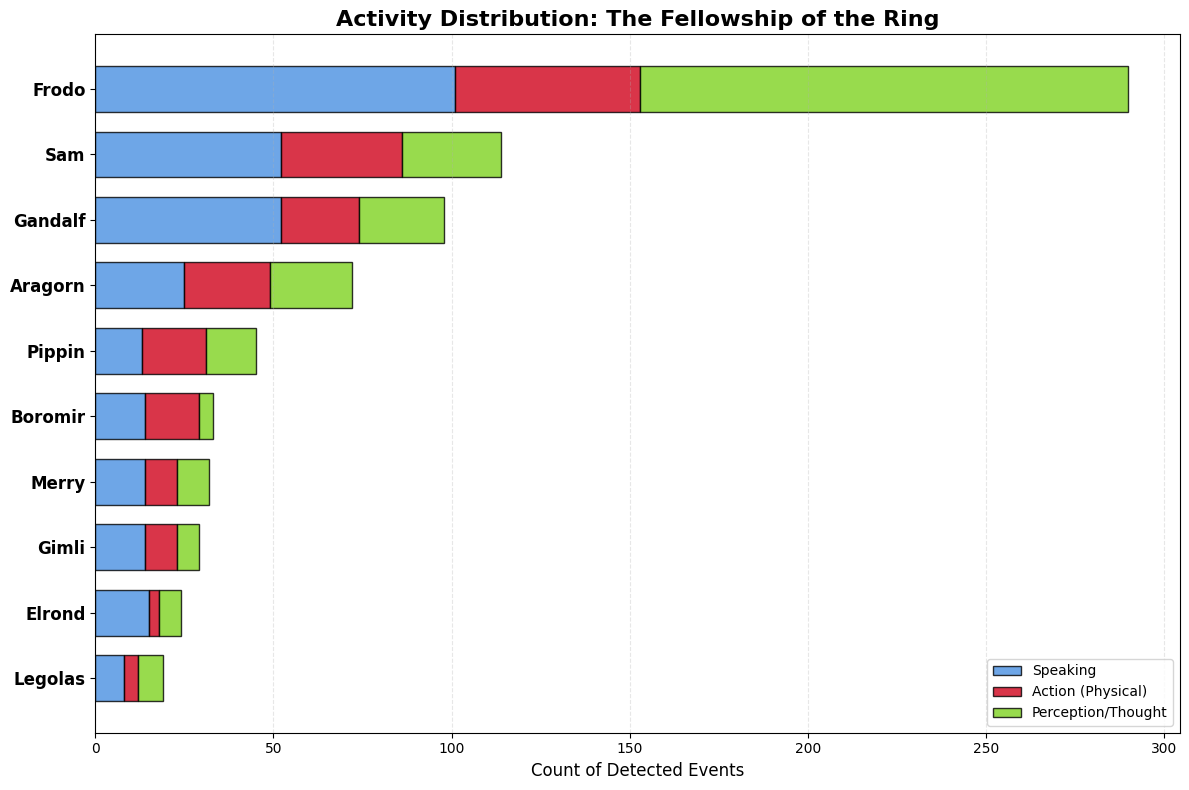

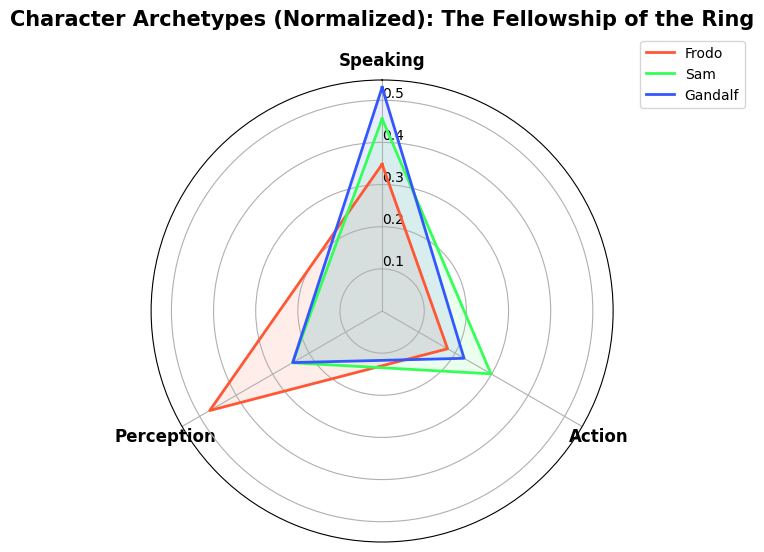


Analyzing The Two Towers...


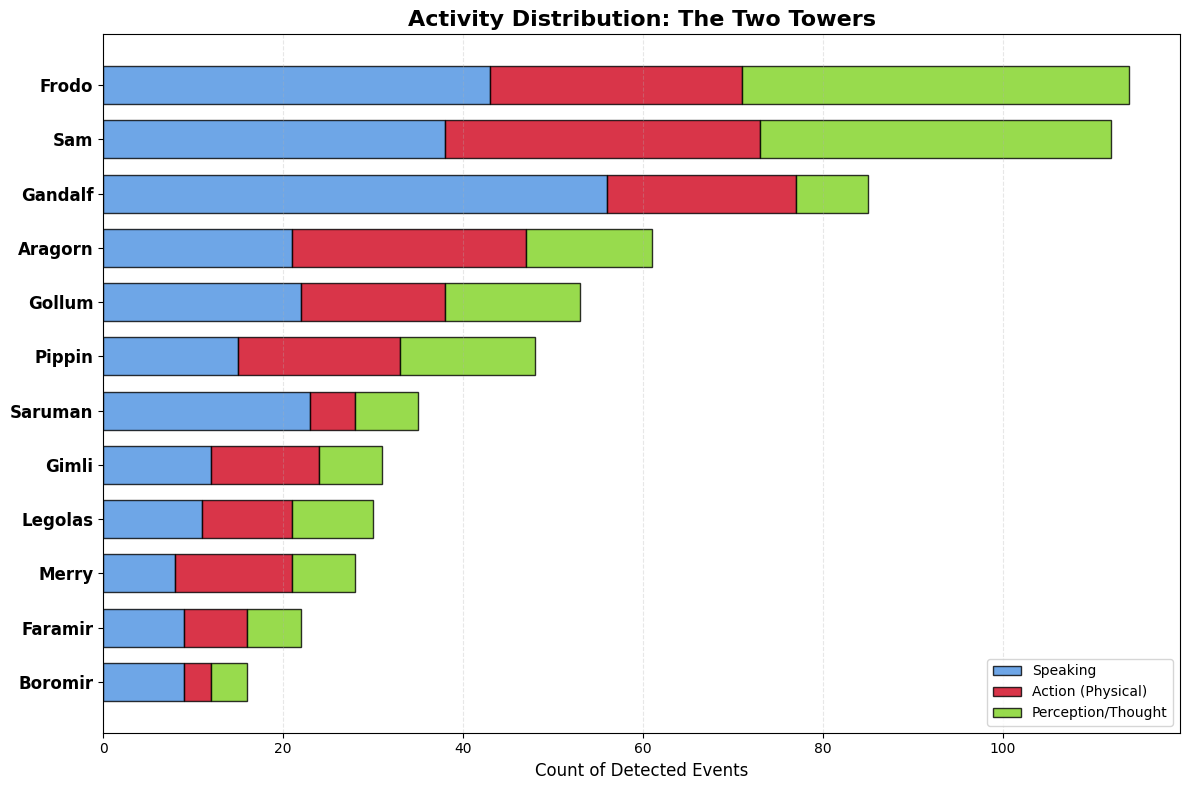

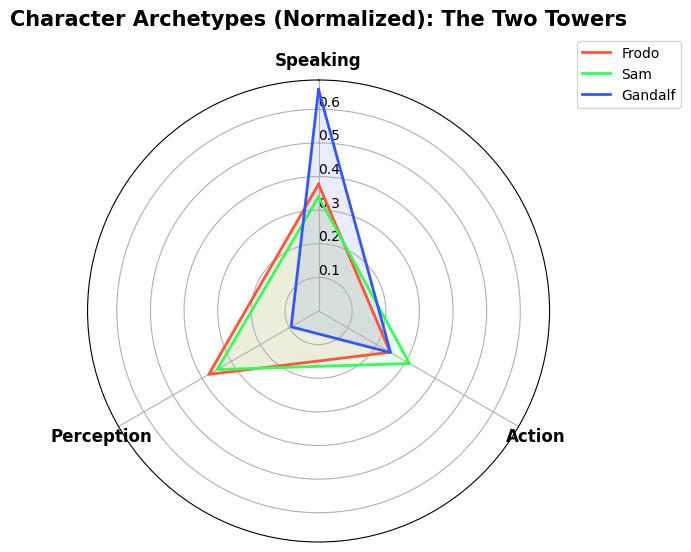


Analyzing The Return of the King...


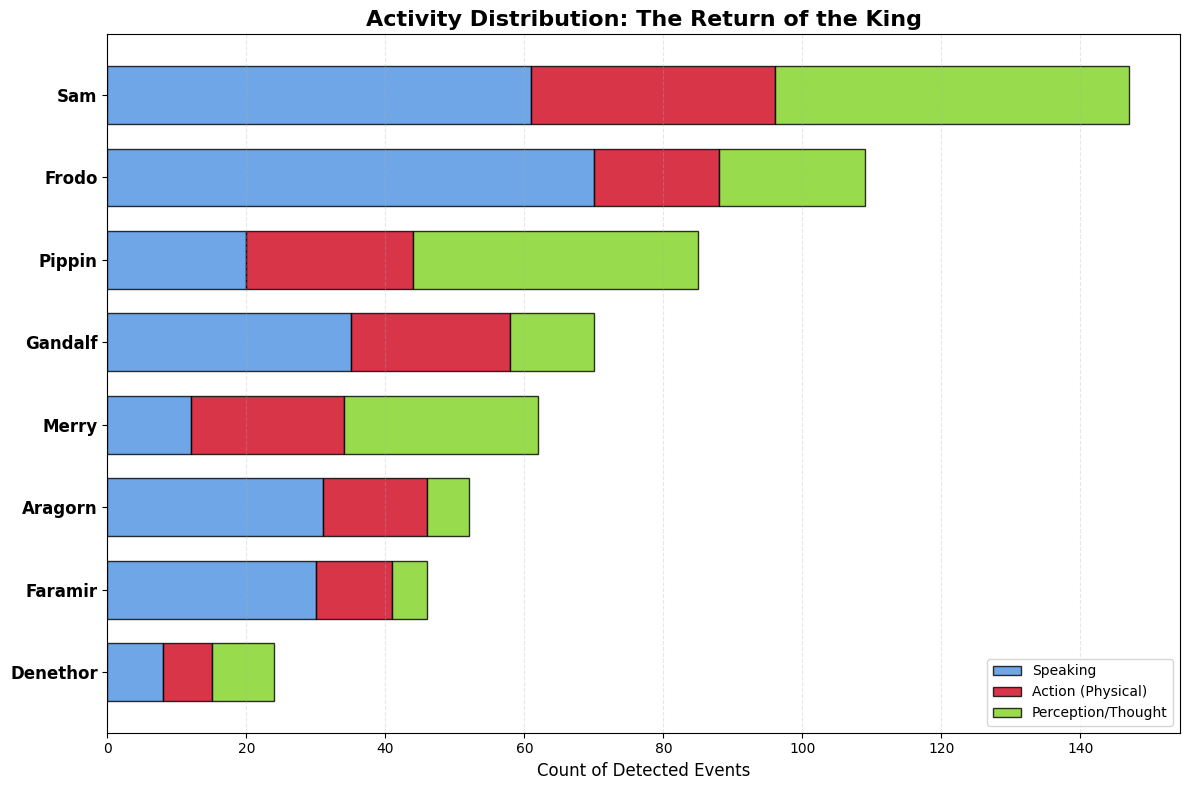

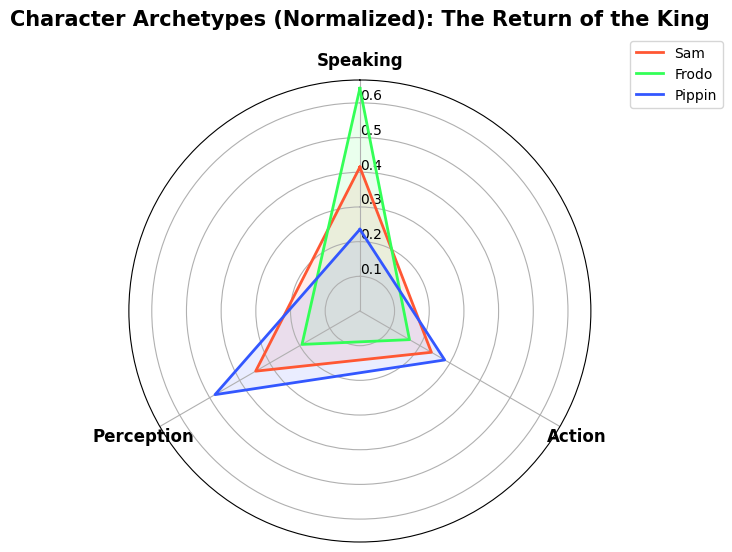

In [2]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- IMPROVED VERB DICTIONARIES ---
# Expanded lists for better coverage
VERB_CATEGORIES = {
    "Speaking": set([
        "said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
        "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
        "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
        "continued", "added", "explained", "agreed", "announced"
    ]),
    "Action (Physical)": set([
        "ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
        "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
        "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
        "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed"
    ]),
    "Perception/Thought": set([
        "saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
        "noticed", "listened", "wondered", "remembered", "feared", "hoped",
        "stared", "glanced", "gazed", "perceived", "understood", "believed", 
        "realized", "guessed"
    ])
}

# Words to ignore when scanning window (adverbs, fillers)
SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    """Loads and tokenizes text."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Strip headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=4):
    """
    Scans for Character + Verb patterns with improved skip-logic.
    """
    stats = defaultdict(lambda: defaultdict(int))
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            
            # Look at the next few words
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue # Skip adverbs to find the verb
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return stats

# --- VISUALIZATION 1: Horizontal Stacked Bar ---
def plot_horizontal_activity(stats, title):
    """
    Horizontal Stacked Bar Chart for easier reading of names.
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars:
        print(f"Not enough data for {title}")
        return

    sorted_chars = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=False) # Ascending for horizontal
    top_chars = sorted_chars[-12:] # Top 12
    
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    data = {cat: [] for cat in categories}
    for char in top_chars:
        for cat in categories:
            data[cat].append(active_chars[char][cat])
            
    fig, ax = plt.subplots(figsize=(12, 8))
    
    bar_width = 0.7
    indices = np.arange(len(top_chars))
    lefts = np.zeros(len(top_chars))
    
    colors = ['#4a90e2', '#d0021b', '#7ed321'] # Blue, Red, Green
    
    for i, cat in enumerate(categories):
        values = np.array(data[cat])
        ax.barh(indices, values, left=lefts, label=cat, height=bar_width, 
               color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values

    ax.set_title(f"Activity Distribution: {title}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Count of Detected Events", fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels(top_chars, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- VISUALIZATION 2: Radar Charts (Spider Plots) ---
def plot_radar_profiles(stats, title):
    """
    Creates Radar Charts for the Top 3 most active characters.
    Shows the 'shape' of their behavior (e.g. Fighter vs Talker).
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars: return

    # Pick top 3 active chars
    top_3 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:3]
    categories = ["Speaking", "Action", "Perception"] # Shortened labels
    
    # Setup Radar Plot
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Close loop
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    colors = ['#FF5733', '#33FF57', '#3357FF']
    
    for i, char in enumerate(top_3):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        # Normalize values to compare shape, not just volume
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] # Close loop
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=colors[i])
        ax.fill(angles, norm_values, color=colors[i], alpha=0.1)

    plt.title(f"Character Archetypes (Normalized): {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Activity Analysis...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    tokens = clean_and_tokenize(path)
    
    if tokens:
        stats = analyze_activity(tokens, ALIAS_MAP)
        # Plot 1: Volume & Breakdown
        plot_horizontal_activity(stats, title)
        # Plot 2: Archetype Shape
        plot_radar_profiles(stats, title)
    else:
        print("Error: No tokens found.")